In [3]:
from swiss_simulator import rounds_for_single_leader, probability_single_leader

# How many rounds so 90% of the time there's one leader? (64 players, 5% draw)
out = rounds_for_single_leader(64, draw_pct=1.5, target_probability=0.9, n_simulations=2000)
print(out["rounds"])               # e.g. 6
print(out["probability_at_rounds"]) # e.g. 0.91

# One-off: P(single leader) for 32 players, 5 rounds, 5% draw
p = probability_single_leader(32, 5, 1.5, n_simulations=5000)

6
0.984


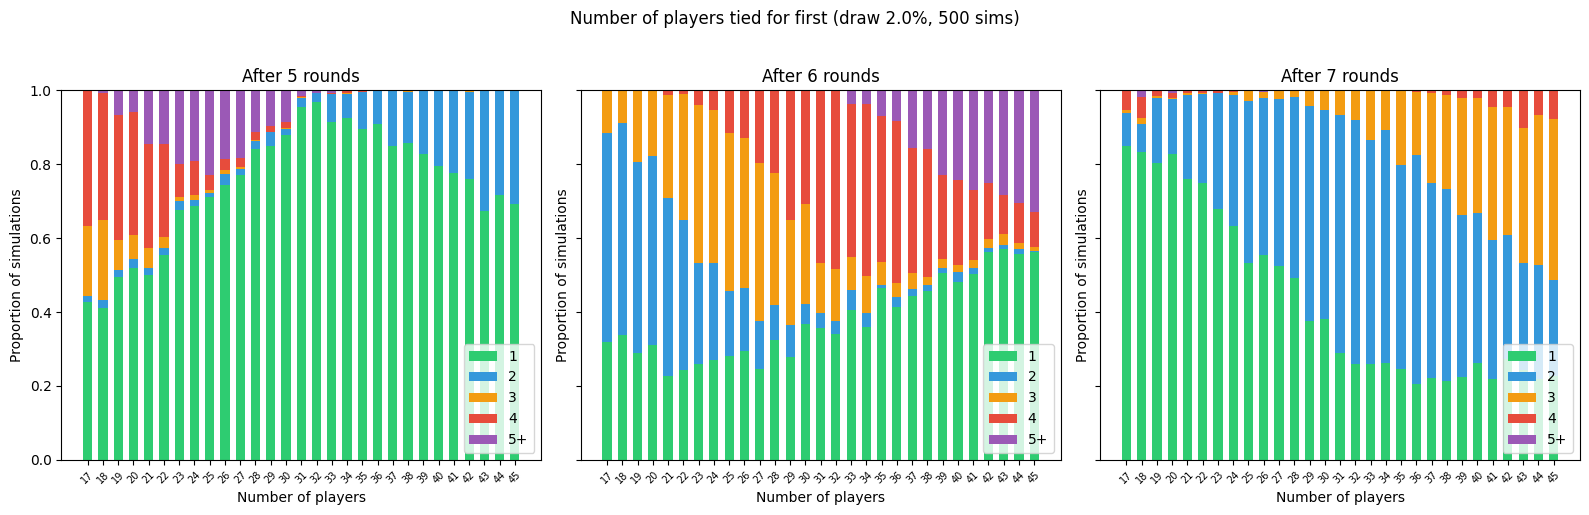

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tournament.tournament import TournamentSimulation


def plot_count_at_top_distributions(
    data, player_counts, round_counts, draw_pct, n_simulations, title=None
):
    """Stacked-bar distribution of number of players tied for first. One subplot per round."""
    n_rounds = len(round_counts)
    fig, axes = plt.subplots(1, n_rounds, figsize=(4 * (1 + n_rounds), 5), sharey=True)
    if n_rounds == 1:
        axes = [axes]
    x = np.array(player_counts)
    width = 0.6
    colors = ["#2ecc71", "#3498db", "#f39c12", "#e74c3c", "#9b59b6"]
    labels = ["1", "2", "3", "4", "5+"]

    for ax, round_num in zip(axes, round_counts):
        bottoms = np.zeros(len(player_counts))
        for k in range(1, 6):
            fracs = [data.get((n, round_num), {}).get(k, 0) for n in player_counts]
            ax.bar(x, fracs, width, bottom=bottoms, label=labels[k - 1], color=colors[k - 1])
            bottoms = bottoms + np.array(fracs)
        ax.set_xlabel("Number of players")
        ax.set_ylabel("Proportion of simulations")
        ax.set_title(f"After {round_num} rounds")
        ax.legend(loc="lower right")
        ax.set_xticks(x)
        ax.tick_params(axis="x", labelsize=7, rotation=45)
        ax.set_ylim(0, 1)

    if title is None:
        title = f"Number of players tied for first (draw {draw_pct}%, {n_simulations} sims)"
    fig.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()


def counts_to_distribution(counts, n_sims, max_bucket=5):
    """Convert list of count-at-top per sim to fractions; bucket 5+ together."""
    hist = {k: 0.0 for k in range(1, max_bucket + 1)}
    for c in counts:
        key = min(c, max_bucket) if c >= 1 else 1
        hist[key] = hist.get(key, 0) + 1
    for k in hist:
        hist[k] /= n_sims
    return hist


player_counts = list(range(17, 46))
round_counts = [5, 6, 7]
draw_pct = 2.0
n_simulations = 500
max_rounds = max(round_counts)

data = {}
for n_players in player_counts:
    per_round_counts, params = TournamentSimulation.run_with_round_snapshots(
        n_players, max_rounds, draw_pct, n_simulations, seed=42
    )
    n_sims = params["simulations"]
    for r in round_counts:
        if r in per_round_counts:
            data[(n_players, r)] = counts_to_distribution(per_round_counts[r], n_sims)

plot_count_at_top_distributions(
    data, player_counts, round_counts, draw_pct, n_simulations
)

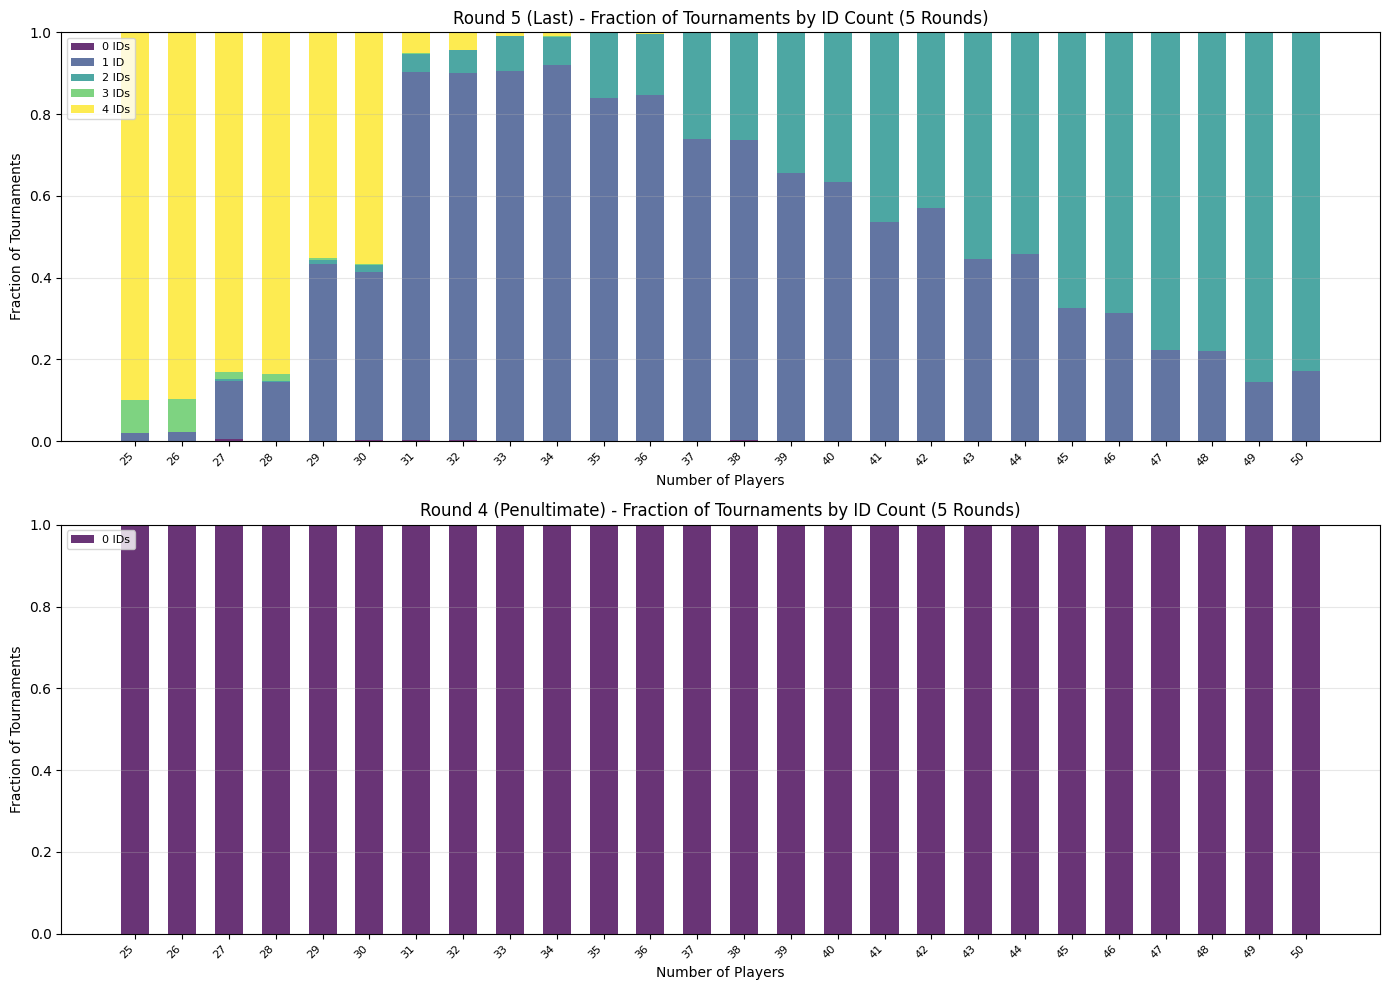

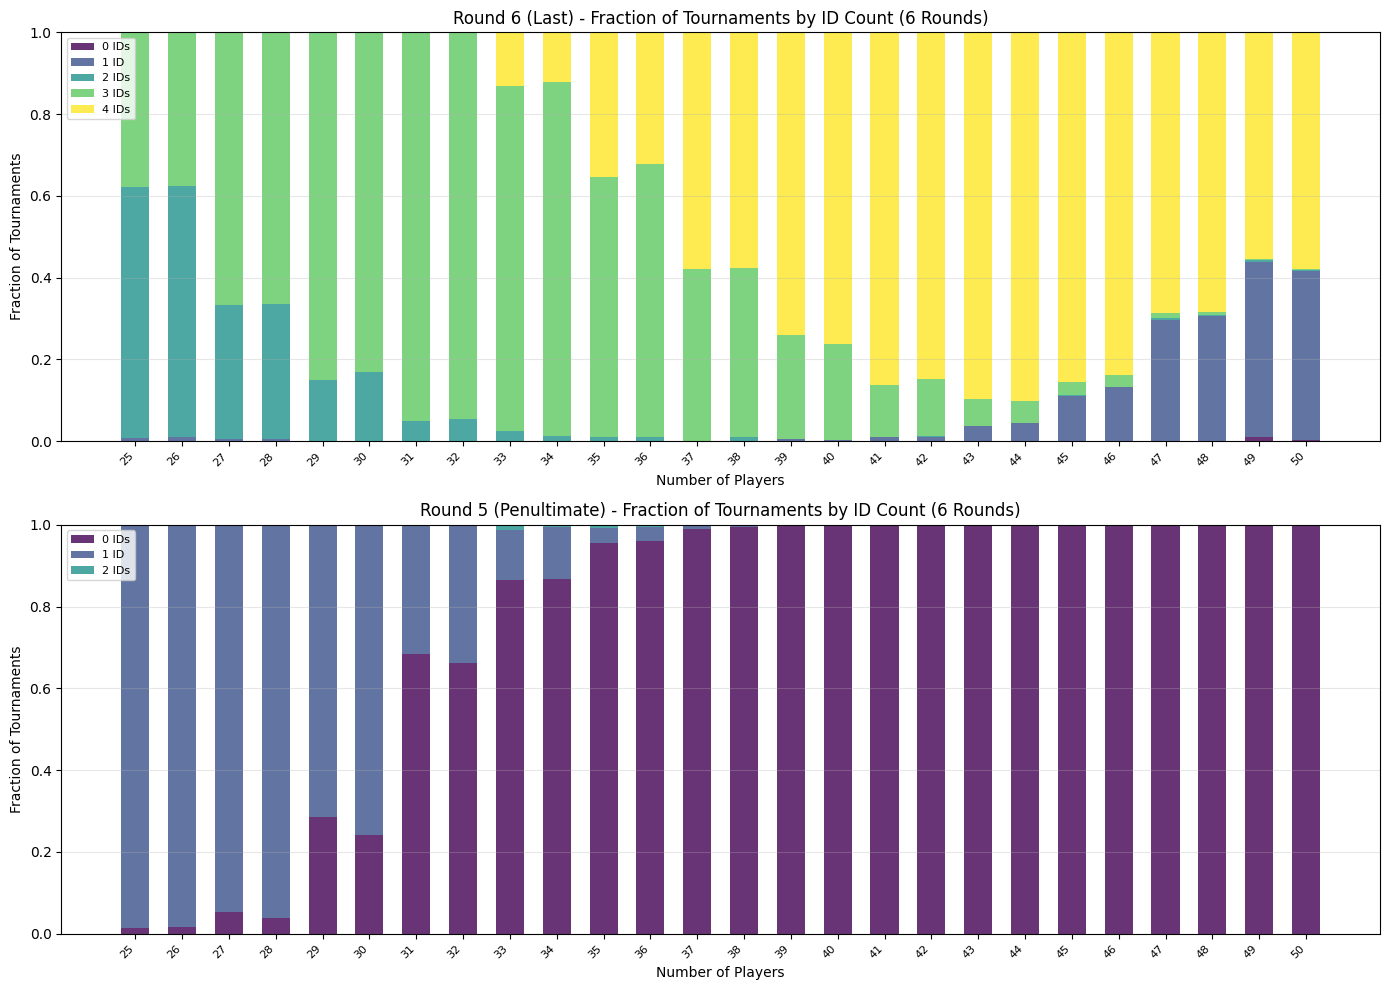

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tournament.tournament import TournamentSimulation


def plot_id_distribution_by_players(rounds, draw_chance=2, simulations=1000, cut_size=8, seed=42):
    """Plot fraction of tournaments with specific ID counts per round vs player count."""
    player_counts = list(range(25, 51))
    
    # Collect data for each round
    last_round = rounds
    penultimate_round = rounds - 1
    
    # Store distributions: {round_num: {player_count: {id_count: fraction}}}
    distributions = {}
    
    # Collect all unique ID counts across all rounds and players
    all_id_counts = set()
    
    for players in player_counts:
        per_round = TournamentSimulation.analyze_intentional_draws_per_round(
            num_players=players,
            num_rounds=rounds,
            draw_percent=draw_chance,
            num_simulations=simulations,
            cut_size=cut_size,
            seed=seed,
        )
        
        for round_num in [last_round, penultimate_round]:
            if round_num not in distributions:
                distributions[round_num] = {}
            distributions[round_num][players] = {}

            if round_num in range(1, rounds + 1):
                dist = per_round[round_num]
                for id_count_str, freq in dist.items():
                    count = int(id_count_str)
                    distributions[round_num][players][count] = freq / simulations
                    all_id_counts.add(count)
    
    all_id_counts = sorted(all_id_counts)
    
    # Create subplots for each round
    rounds_to_plot = []
    round_labels = []
    
    if any(distributions[last_round][pc] for pc in player_counts):
        rounds_to_plot.append(last_round)
        round_labels.append(f'Round {last_round} (Last)')
    
    if any(distributions[penultimate_round][pc] for pc in player_counts):
        rounds_to_plot.append(penultimate_round)
        round_labels.append(f'Round {penultimate_round} (Penultimate)')
        
    if not rounds_to_plot:
        return None
    
    fig, axes = plt.subplots(len(rounds_to_plot), 1, figsize=(14, 5 * len(rounds_to_plot)))
    if len(rounds_to_plot) == 1:
        axes = [axes]
    
    x = np.arange(len(player_counts))
    width = 0.6
    
    # Color map for different ID counts
    colors = plt.cm.viridis(np.linspace(0, 1, len(all_id_counts)))
    
    for idx, (round_num, round_label) in enumerate(zip(rounds_to_plot, round_labels)):
        ax = axes[idx]
        
        # Prepare data for stacked bars
        bottom = np.zeros(len(player_counts))
        
        # Plot bars for each ID count
        for id_count in all_id_counts:
            fractions = []
            for players in player_counts:
                fraction = distributions[round_num][players].get(id_count, 0.0)
                fractions.append(fraction)
            
            if any(fractions):  # Only plot if there's at least one non-zero value
                ax.bar(x, fractions, width, bottom=bottom, 
                      label=f'{id_count} ID{"s" if id_count != 1 else ""}',
                      alpha=0.8, color=colors[all_id_counts.index(id_count)])
                bottom += np.array(fractions)
        
        ax.set_xlabel('Number of Players', fontsize=10)
        ax.set_ylabel('Fraction of Tournaments', fontsize=10)
        ax.set_title(f'{round_label} - Fraction of Tournaments by ID Count ({rounds} Rounds)', fontsize=12)
        ax.set_xticks(x)
        ax.set_xticklabels(player_counts, rotation=45, ha='right', fontsize=8)
        ax.set_ylim([0, 1])
        ax.legend(loc='upper left', fontsize=8, ncol=1)
        ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    return fig

# Create plots for rounds=5 and rounds=6
fig1 = plot_id_distribution_by_players(rounds=5)
fig2 = plot_id_distribution_by_players(rounds=6)

plt.show()